In [279]:
import os
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [220]:
train_data_path = './data/train'

In [210]:
test_data_path = './data/test'

In [226]:
mean = [0.4988, 0.5055, 0.4998]

In [227]:
std = [0.2169, 0.2055, 0.2387]

In [229]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    
])

In [235]:
#изменить размер
#преобразовать в тензор
#нормализовать
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [236]:
train_dataset = torchvision.datasets.ImageFolder(root = train_data_path, transform = train_transforms)

In [237]:
test_dataset = torchvision.datasets.ImageFolder(root = test_data_path, transform = train_transforms)

In [224]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

    mean /= total_images_count
    std /= total_images_count


    return mean, std

In [278]:
#get_mean_and_std(train_loader)

(tensor([-0.0824, -0.0930, -0.0827]), tensor([1.0825, 1.0934, 1.0627]))

In [238]:
def show_new_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4598541..2.4063258].


labels tensor([3, 7, 1, 0, 7, 5])


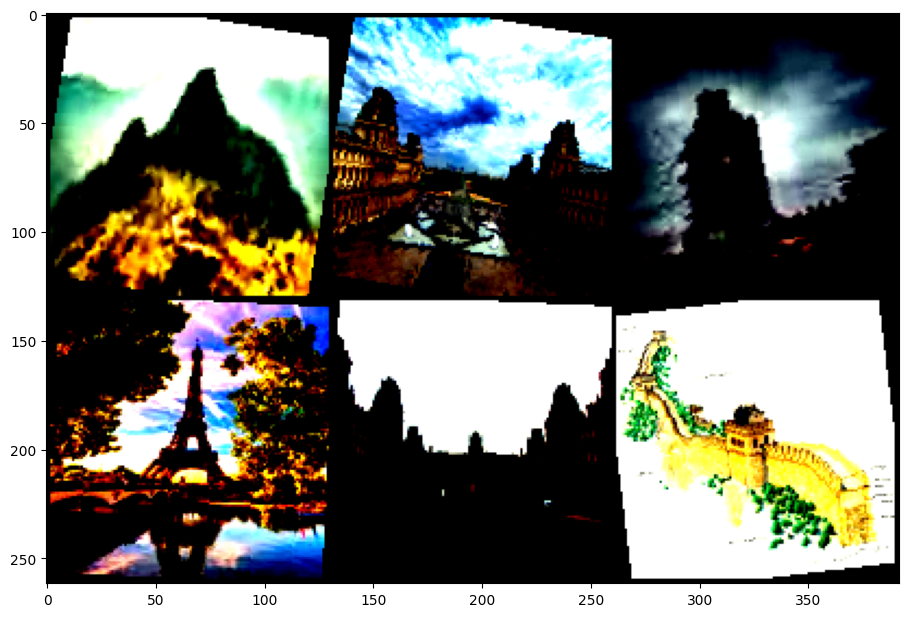

In [239]:
show_new_images(train_dataset)

In [240]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=16, shuffle=True)

In [241]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=16, shuffle=True)

In [242]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [243]:
image, _ = train_dataset[0]

In [244]:
conv= nn.Conv2d(3, 1, kernel_size=3, padding=1)
image.shape

torch.Size([3, 128, 128])

In [245]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [246]:
pool = nn.MaxPool2d(2)
output = pool(image.unsqueeze(0))
image.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1, 3, 64, 64]))

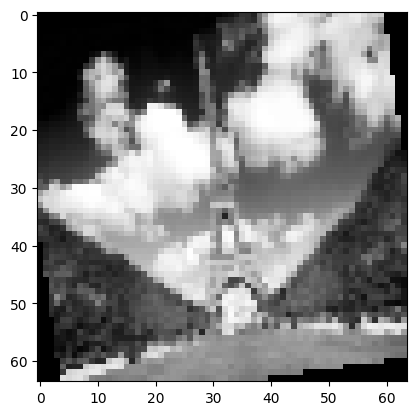

In [247]:
plt.imshow(output[0, 0].detach(), cmap='gray')

In [248]:
class_names = ["Eiffel Tower_1", "Taj-Mahal_2", "machu picchu_3", "Coliseum_4", 
               "Great Wall of China_5", "Acropolis of Athens_6", "Louvre_7", 
               "Moscow Kremlin_8", "Milan Cathedral_9", "big ben_10"]

In [249]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128 * 16 * 16), 128)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) # -> Outputs: (32, 128, 128)
        x = self.pooling(x)# -> Outputs: (32, 64, 64)
        x = self.relu(x)
        
        x = self.conv2(x) # -> Outputs: (64, 64, 64)
        x = self.pooling(x) # -> Outputs: (64, 32, 32)
        x = self.relu(x)
      
        x = self.conv3(x) # -> Outputs: (128, 32, 32)
        x = self.pooling(x) # -> Outputs: (128, 16, 16)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x
        

In [250]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [251]:
model = Net().to(device)
#model(image.unsqueeze(0))

In [252]:
########################################
model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [106]:
dummy_input = torch.randn(1, 3, 128, 128)
print(f"Форма входного тензора: {dummy_input.shape}")

Форма входного тензора: torch.Size([1, 3, 128, 128])


In [105]:
try:
    with torch.no_grad():
        output = model(dummy_input)

    if isinstance(output, torch.Tensor):
        print(f"Форма выходного тензора: {output.shape}")
    elif isinstance(output, (list, tuple)):
        print("Модель вернула несколько выходов:")
        for i, out_tensor in enumerate(output):
            if isinstance(out_tensor, torch.Tensor):
                print(f" Выход {i}, форма: {out_tensor.shape}")
            else:
                print(f" Выход {i} не является тензором: {type(out_tensor)}")
    else:
        print(f"Модель вернула непонятную хрень: {type(output)}")

except Exception as e:
    print(f"Произошла ошибка во время прямого прохода {e}")
    import traceback
    traceback.print_exc()

Форма выходного тензора: torch.Size([1, 10])


In [253]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128));

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            4,194,432
├─Linear: 1-8                            1,290
Total params: 4,288,970
Trainable params: 4,288,970
Non-trainable params: 0


In [254]:
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)


In [255]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(4288970, [864, 32, 18432, 64, 73728, 128, 4194304, 128, 1280, 10])

In [256]:
import datetime

In [170]:
def training_loop(n_epochs, optimizer, model, loss_function, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch{}, Training Loss {}".format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [261]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=16, shuffle=False)

In [258]:
model = Net().to(device)

In [259]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [260]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_function = loss_function,
    train_loader = train_loader)

2025-05-25 02:42:24.608836 Epoch1, Training Loss 2.26926725468737
2025-05-25 02:45:10.512800 Epoch10, Training Loss 1.4666243969125952
2025-05-25 02:48:39.052885 Epoch20, Training Loss 0.7746072551037403
2025-05-25 02:51:52.394754 Epoch30, Training Loss 0.33357775892983094
2025-05-25 02:54:47.402021 Epoch40, Training Loss 0.21662604297570726
2025-05-25 02:57:47.751482 Epoch50, Training Loss 0.05821899374689352
2025-05-25 03:01:10.053686 Epoch60, Training Loss 0.03653049146622776
2025-05-25 03:04:19.440447 Epoch70, Training Loss 0.02530262207468734
2025-05-25 03:07:16.247730 Epoch80, Training Loss 0.004692314570383268
2025-05-25 03:10:13.350694 Epoch90, Training Loss 0.004217866917934635
2025-05-25 03:13:25.774515 Epoch100, Training Loss 0.0019299709221083136


In [262]:
val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=16, shuffle=False)

In [263]:
#8.4.1
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs= model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [264]:
validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.67


In [265]:
torch.save(model.state_dict(), train_data_path + "landmarks.pt")

In [266]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(train_data_path + "landmarks.pt"))

<All keys matched successfully>

In [268]:
#пример с рандомными картинками
from PIL import Image

In [270]:
new_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [271]:
def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image

In [272]:
image_path = ["example_1.jpg", "example_2.jpg"]

In [273]:
images = [load_image(img) for img in image_path]

In [274]:
model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [277]:
with torch.no_grad():
    for image in images:
        image = image.to(device=device)
        #labels = labels.to(device=device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        print(f"Prediction: {class_names[predicted.item()]}")

Prediction: Eiffel Tower_1
Prediction: Great Wall of China_5


In [49]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1,  8 * 8 * self.n_chans1 // 2)
        out = self.fc2(out)
        return out

In [50]:
sum(p.numel() for p in model.parameters())

18354

In [52]:
#L2 - regularization
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_function(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [ ]:
#Dropout
